In [7]:
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.utils as vutils
import torch.nn.functional as nnf
import random
torch.manual_seed(0)

import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

import os

from skimage.transform import rescale, resize
from skimage import io
from skimage.metrics import peak_signal_noise_ratio
from skimage.color import rgb2gray

from PIL import Image

from libs.gpp.models2 import *
from libs.gpp.experiment_funcs import *
from bm4d import bm4d, BM4DProfile, BM4DStages

In [8]:
genPATH = './all_models/overfit_blood_cell.pt'


workers = 2
ngpu = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
nz_ = 100
batch_size= 8

cuda:0


In [9]:
# Define a simple forward model y = Ax
class ForwardModel(nn.Module):
    def __init__(self, A):
        super(ForwardModel, self).__init__()
        self.A = nn.Parameter(A, requires_grad=False)

    def forward(self, x):
        # Flatten input x if it's not already flattened
        if x.dim() != 2:
            x = x.view(x.size(0), -1)
        return  (self.A@x.squeeze())

In [10]:
def bm4dDenoiser(img_3d):
    # Possible noise types to be generated 'gw', 'g1', 'g2', 'g3', 'g4', 'g1w',
    # 'g2w', 'g3w', 'g4w'.
    noise_type = 'g1'
    noise_var = 0.1
    seed = 0                                        # seed for pseudorandom noise realization

    # Generate noise with given PSD
    kernel = get_experiment_kernel(noise_type, noise_var)
    noise, psd, kernel = generate_noise(kernel, seed, img_3d.shape)
    
    # Basic filtering operation
    z = np.atleast_3d(img_3d)

    # Generate noisy image corrupted by additive spatially correlated noise
    # z = np.atleast_3d(img_3d) + np.atleast_3d(noise)

    # Call BM4D With the default settings.
    # obj_est = bm4d(z, psd)

    # For 8x8x1 blocks instead of 4x4x4/5x5x5
    # obj_est = bm4d(z, psd, '8x8')

    # To include refiltering:
    obj_est = bm4d(z, psd, 'refilter')

    # For other settings, use BM4DProfile.
    # profile = BM4DProfile(); # equivalent to profile = BM4DProfile('np');
    # profile.gamma = 6;  # redefine value of gamma parameter
    # obj_est = bm4d(z, psd, profile)

    # Note: For white noise, you may instead of the PSD
    # also pass a standard deviation
    # obj_est = bm4d(z, sqrt(noise_var))

    # Call BM4D HT With the default settings.
    # obj_est = bm4d(z, psd, stage_arg=BM4DStages.HARD_THRESHOLDING)

    # Call BM4D HT With sharpening
    # profile = BM4DProfile()
    # profile.sharpen_alpha = 1.5
    # profile.sharpen_alpha_3d = 1.1
    # profile.set_sharpen(1.2)
    # obj_est = bm4d(z, psd, profile, stage_arg=BM4DStages.HARD_THRESHOLDING)

    # For 2-D filtering
    # profile = BM4DProfileBM3D()
    # profile.set_sharpen(1.2)
    # noise, psd, kernel = generate_noise(kernel, seed, (y.shape[0], y.shape[1], 1))
    # y_est_s = bm4d(z[:, :, 24], psd, profile, stage_arg=BM4DStages.HARD_THRESHOLDING)


    return obj_est

In [11]:
# Function to add noise with specific SNR to a clean signal
def add_noise_with_snr(clean_signal, snr_db):
    clean_power = torch.mean(clean_signal ** 2)
    snr_linear = 10 ** (snr_db / 10)
    noise_power = clean_power / snr_linear
    noise = torch.randn_like(clean_signal) * torch.sqrt(noise_power)
    noisy_signal = clean_signal + noise
    return noisy_signal

In [12]:
netG = Generator(ngpu=ngpu, nc = 1).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)


if os.path.isfile(genPATH):
    if device.type == 'cuda':
        netG.load_state_dict(torch.load(genPATH))
    elif device.type=='cpu':
        netG.load_state_dict(torch.load(genPATH,map_location=torch.device('cpu')))
    else:
        raise Exception("Unable to load model to specified device")

    print("************ Generator weights restored! **************")
    netG.eval()

************ Generator weights restored! **************


Linearized Model Specifications
----------------------------------------------
NA 				: 0.8
Space Dimension 		: 32.000um × 32.000um × 8.000um
Voxel Size 			: 1.0um × 1.0um × 1.0um
Original Shape 			: 32 × 32 × 8
DMD Patch Size 			: 2.0um × 2.0um
DMD Patterns 			: 32
# of Plane			: 1
Detector Pool size 		: 2×2
Computational Device 		: cuda




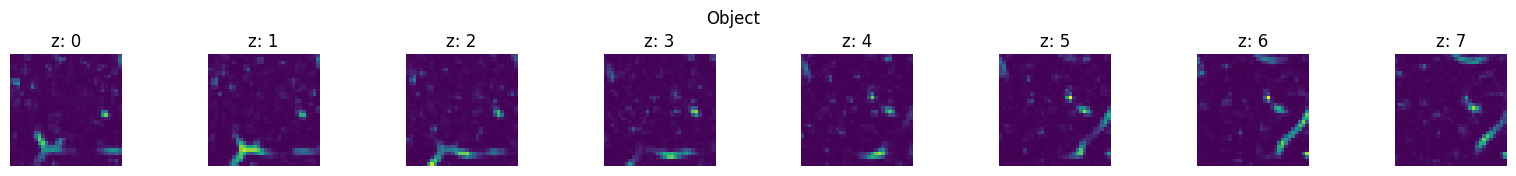

In [23]:
from libs.forward_lib.linearized_process import LinearizedModel
from libs.forward_lib.read_data import ReadData
import torch
import numpy as np

nx, ny, nz = 32, 32, 8

LM = LinearizedModel()
LM.load_matrix(it = 100, is_original=False)
print(LM)


b = 784
X =  torch.load("./data/dataset/object/Xr_blood_cell.pt")[b].to(LM.device)

RD_o = ReadData(nx, ny, nz)
RD_r = ReadData(nx, ny, nz)
RD_o.X = X.view(1, nz, nx, ny)
RD_o.visualize_data(is_orginal=True)


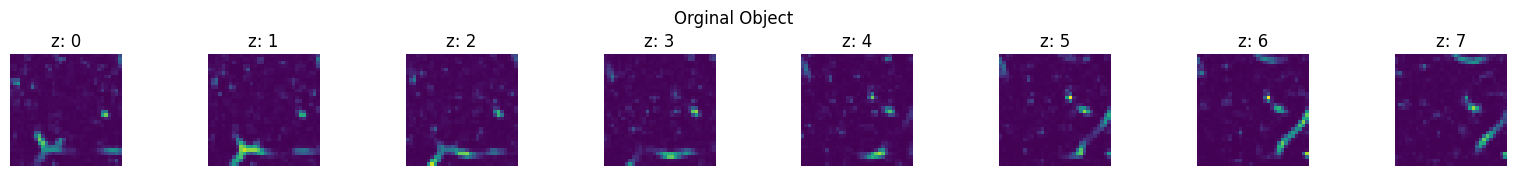

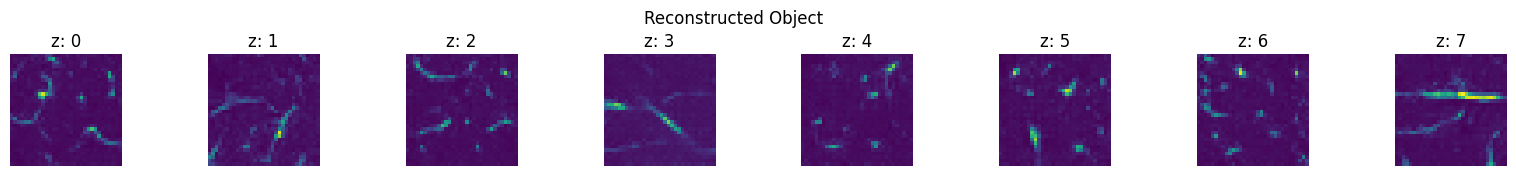

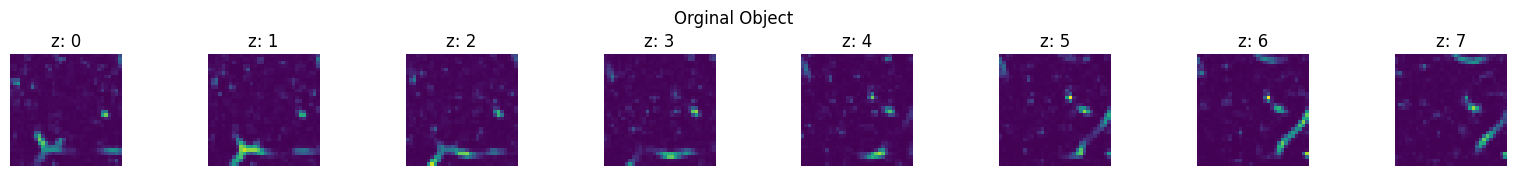

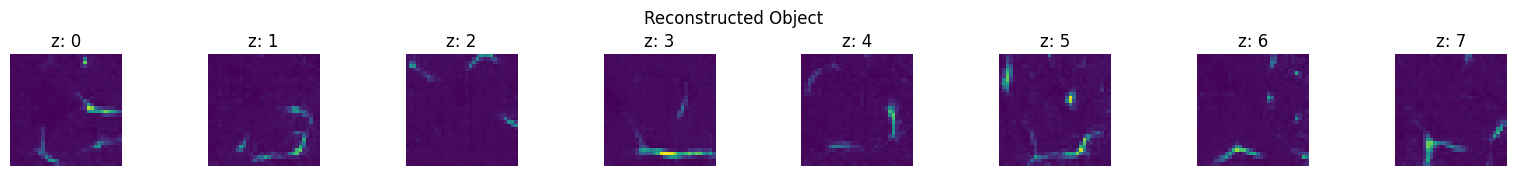

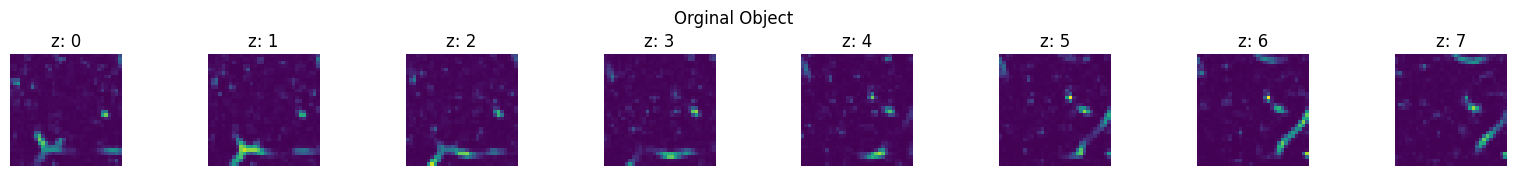

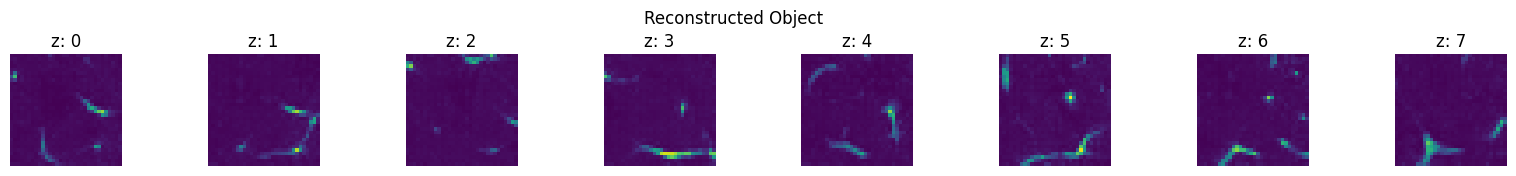

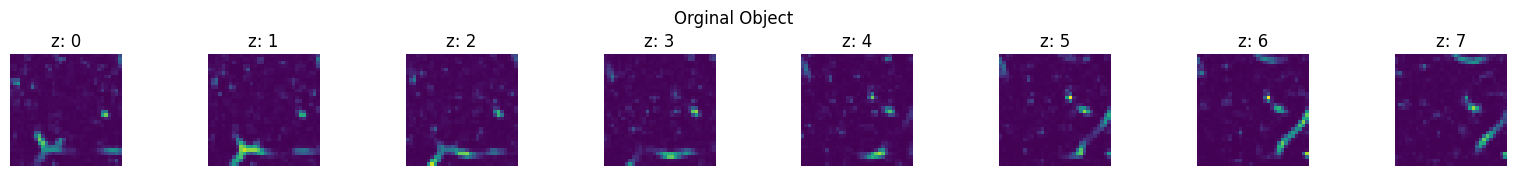

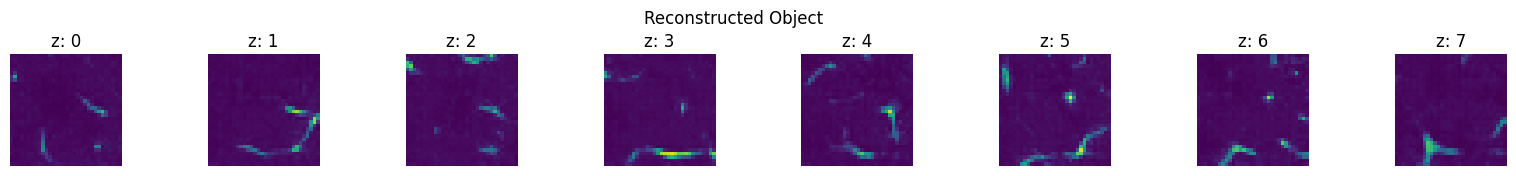

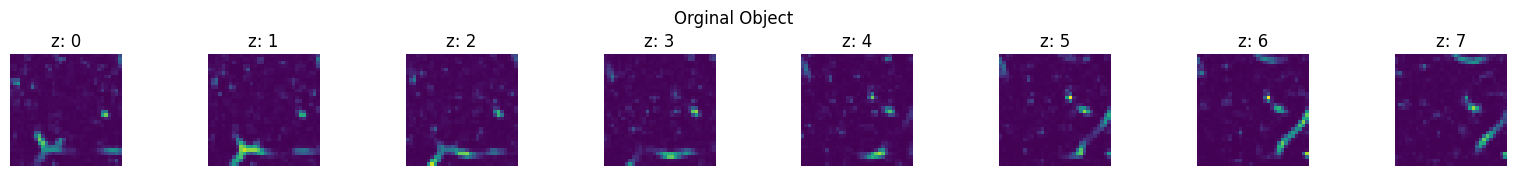

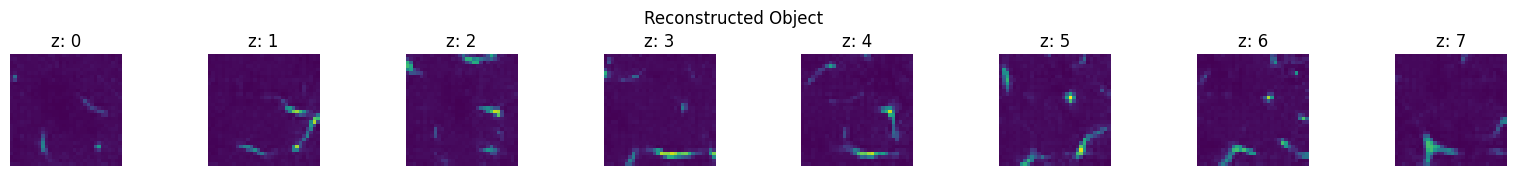

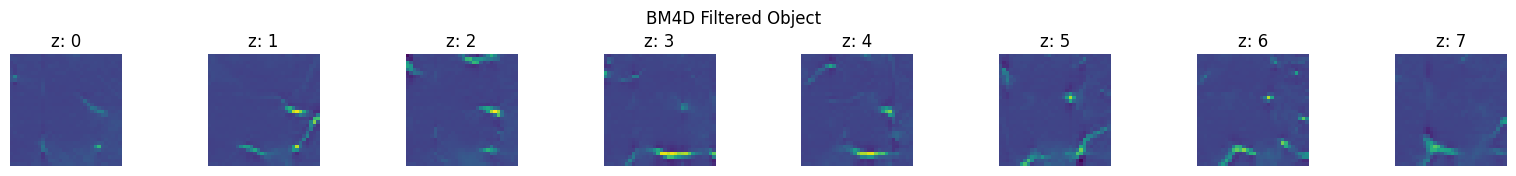

In [26]:
n_measure = 4096
y_clean  = torch.load("./data/dataset/measurement/Y_blood_cell.pt")[b].to(LM.device)[:n_measure]
y_noisy = add_noise_with_snr(y_clean, 20)
FM = ForwardModel(LM.A[:n_measure,:])


for param in netG.parameters():
    param.requires_grad = False

criterion = nn.SmoothL1Loss()
z_prior = torch.randn(batch_size,nz_,1,1,requires_grad=True,device=device)

optimizerZ = optim.RMSprop([z_prior], lr=5e-4)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizerZ, gamma=0.9999)


for iters in range(10001):
    fake = 0.5*netG(z_prior)+.5 
    fake = nnf.interpolate(fake, size=(32, 32), mode='bilinear', align_corners=False)
    y_est = FM(fake.view(8*32*32))
    cost = criterion(y_est, y_noisy)
    optimizerZ.zero_grad()
    cost.backward()
    optimizerZ.step()
    if (iters+1)%100==0:
        lr_scheduler.step()

    if (iters % 2500 == 0):
        with torch.no_grad():
            RD_r.X = fake.view(1, nz, nx, ny)
            RD_o.visualize_data(is_orginal=True, title = "Orginal Object")
            RD_r.visualize_data(is_orginal=True, title = "Reconstructed Object")

fake_ = fake.permute(1,0, 2,3).squeeze().detach().cpu().numpy()
fake = torch.from_numpy(bm4dDenoiser(fake_)).unsqueeze(0).permute(1,0,2,3).float().to(device)
RD_r.X = fake.view(1, nz, nx, ny)
RD_r.visualize_data(is_orginal=True, title="BM4D Filtered Object")